# Check cell true trace

_Before cells' extracellular potentials are summed into lfp_

This is only available from ground truth experiment/simulations.


**Regression-testing:** [05.07.2023]

- spike spatial variation figure: OK

# Setup 

Activate `spikeinterf..` (get requirements from npx-384 git branch)

In [58]:
%load_ext autoreload
%autoreload 2

import logging
import logging.config
import yaml 
import os
import pprint as pp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd; 
import json
from datetime import datetime
import pandas as pd
import matplotlib
import spikeinterface as si
#import bluepysnap
import neurom as nm
from neurom.view import plotly_impl

# move to project path
with open("./proj_cfg.yml", "r", encoding="utf-8") as proj_cfg:
    PROJ_PATH = yaml.load(proj_cfg, Loader=yaml.FullLoader)["proj_path"]
os.chdir(PROJ_PATH)

from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.load import load_campaign_params

# SET CONFIG PARAM
CHANNEL_IDS = np.arange(64,80).tolist()                           # plot traces from channels nearest to filtered neuron group

# SETUP CONFIG
data_conf, param_conf = get_config("silico_reyes", "2023_01_11").values()
data_conf_full_circuit, _ = get_config("silico_neuropixels", "npx_spont").values()

# isolated cell
ISOLATED_CELL_RAW_PATH = data_conf["probe_wiring_isolated_cell"]["full"]["input"]
ISOLATED_CELL_REC_PATH = data_conf["probe_wiring_isolated_cell"]["full"]["output"]
GT_ISOLATED_CELL_PATH = data_conf["ground_truth"]["full"]["output"]
circuit_path = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805-pure-sonata/circuit_config.json" # full circuit can be dowloaded (300GB though)

CELL = 3754013 # the most active pyramidal cell (layer 5)
SFREQ = param_conf["sampling_freq"]

# cell morphology parameters 
FEATURES = [
    "total_length",
    "total_height",
    "total_area",
    "number_of_sections",
    "section_lengths",
]
NEURITES = {
    "apical": nm.core.types.NeuriteType.apical_dendrite,
    "basal": nm.core.types.NeuriteType.basal_dendrite,
    "axon": nm.core.types.NeuriteType.axon,
}

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-11-21 12:59:01,043 - root - utils.py - get_config - INFO - Reading experiment config.
2024-11-21 12:59:01,067 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-11-21 12:59:01,068 - root - utils.py - get_config - INFO - Reading experiment config.
2024-11-21 12:59:01,104 - root - utils.py - get_config - INFO - Reading experiment config. - done


**Trace data description**

In [59]:
cell_trace = pd.read_pickle(ISOLATED_CELL_RAW_PATH)
cell_trace

contact,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
time,,,,,,,,,,,,,,,,,,,,,
0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.05,4.085209e-07,4.149662e-07,4.117478e-07,3.961939e-07,3.662417e-07,3.211508e-07,2.620635e-07,1.922216e-07,1.167273e-07,4.132322e-08,...,-4.675192e-08,-2.160839e-07,-3.772431e-07,-5.096762e-07,-6.008838e-07,-6.495970e-07,-6.612717e-07,-6.475194e-07,-6.108052e-07,-5.735339e-07
0.10,6.108059e-07,6.265054e-07,6.291554e-07,6.144989e-07,5.791312e-07,5.212871e-07,4.418467e-07,3.443373e-07,2.359972e-07,1.248999e-07,...,2.204069e-08,-2.121559e-07,-4.416914e-07,-6.371887e-07,-7.785264e-07,-8.622193e-07,-8.924056e-07,-8.860252e-07,-8.484813e-07,-8.055820e-07
0.15,7.680952e-07,7.922374e-07,8.008026e-07,7.880760e-07,7.496961e-07,6.830425e-07,5.886737e-07,4.702246e-07,3.364301e-07,1.971021e-07,...,1.258441e-07,-1.544554e-07,-4.360908e-07,-6.828857e-07,-8.682948e-07,-9.861933e-07,-1.039043e-06,-1.046241e-06,-1.016071e-06,-9.759249e-07
0.20,9.026156e-07,9.343940e-07,9.485286e-07,9.379467e-07,8.975065e-07,8.238284e-07,7.171703e-07,5.813957e-07,4.261700e-07,2.627621e-07,...,2.378855e-07,-7.852216e-08,-4.030642e-07,-6.938996e-07,-9.190189e-07,-1.069444e-06,-1.145903e-06,-1.168998e-06,-1.149118e-06,-1.115085e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39999.75,4.972851e-06,5.147994e-06,5.261207e-06,5.288515e-06,5.206028e-06,4.992305e-06,4.632133e-06,4.119865e-06,3.460221e-06,2.671767e-06,...,8.552002e-06,7.835588e-06,6.768867e-06,5.405349e-06,3.827341e-06,2.128033e-06,3.948261e-07,-1.299412e-06,-2.882210e-06,-4.307286e-06
39999.80,4.955814e-06,5.129873e-06,5.242249e-06,5.269165e-06,5.186861e-06,4.974028e-06,4.615496e-06,4.105575e-06,3.448858e-06,2.663674e-06,...,8.547591e-06,7.836433e-06,6.775633e-06,5.417814e-06,3.844567e-06,2.148706e-06,4.174939e-07,-1.275544e-06,-2.858958e-06,-4.284867e-06
39999.85,4.940416e-06,5.113509e-06,5.225146e-06,5.251722e-06,5.169592e-06,4.957565e-06,4.600504e-06,4.092672e-06,3.438570e-06,2.656314e-06,...,8.543164e-06,7.836516e-06,6.780843e-06,5.428022e-06,3.859034e-06,2.166346e-06,4.370735e-07,-1.254726e-06,-2.838501e-06,-4.265009e-06


```diff
- Results: We validated that, as expected, a cell's spike timestamps are synchronized with its extracellular action potentials. Its action potential peak amplitudes gradually 1) go down as we move away from channel 71 (the channel nearest to its true location) and 2) gradually transitions from negative to positive as we move from the leftward channels of channel 71 to its rightward channels.
````

[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


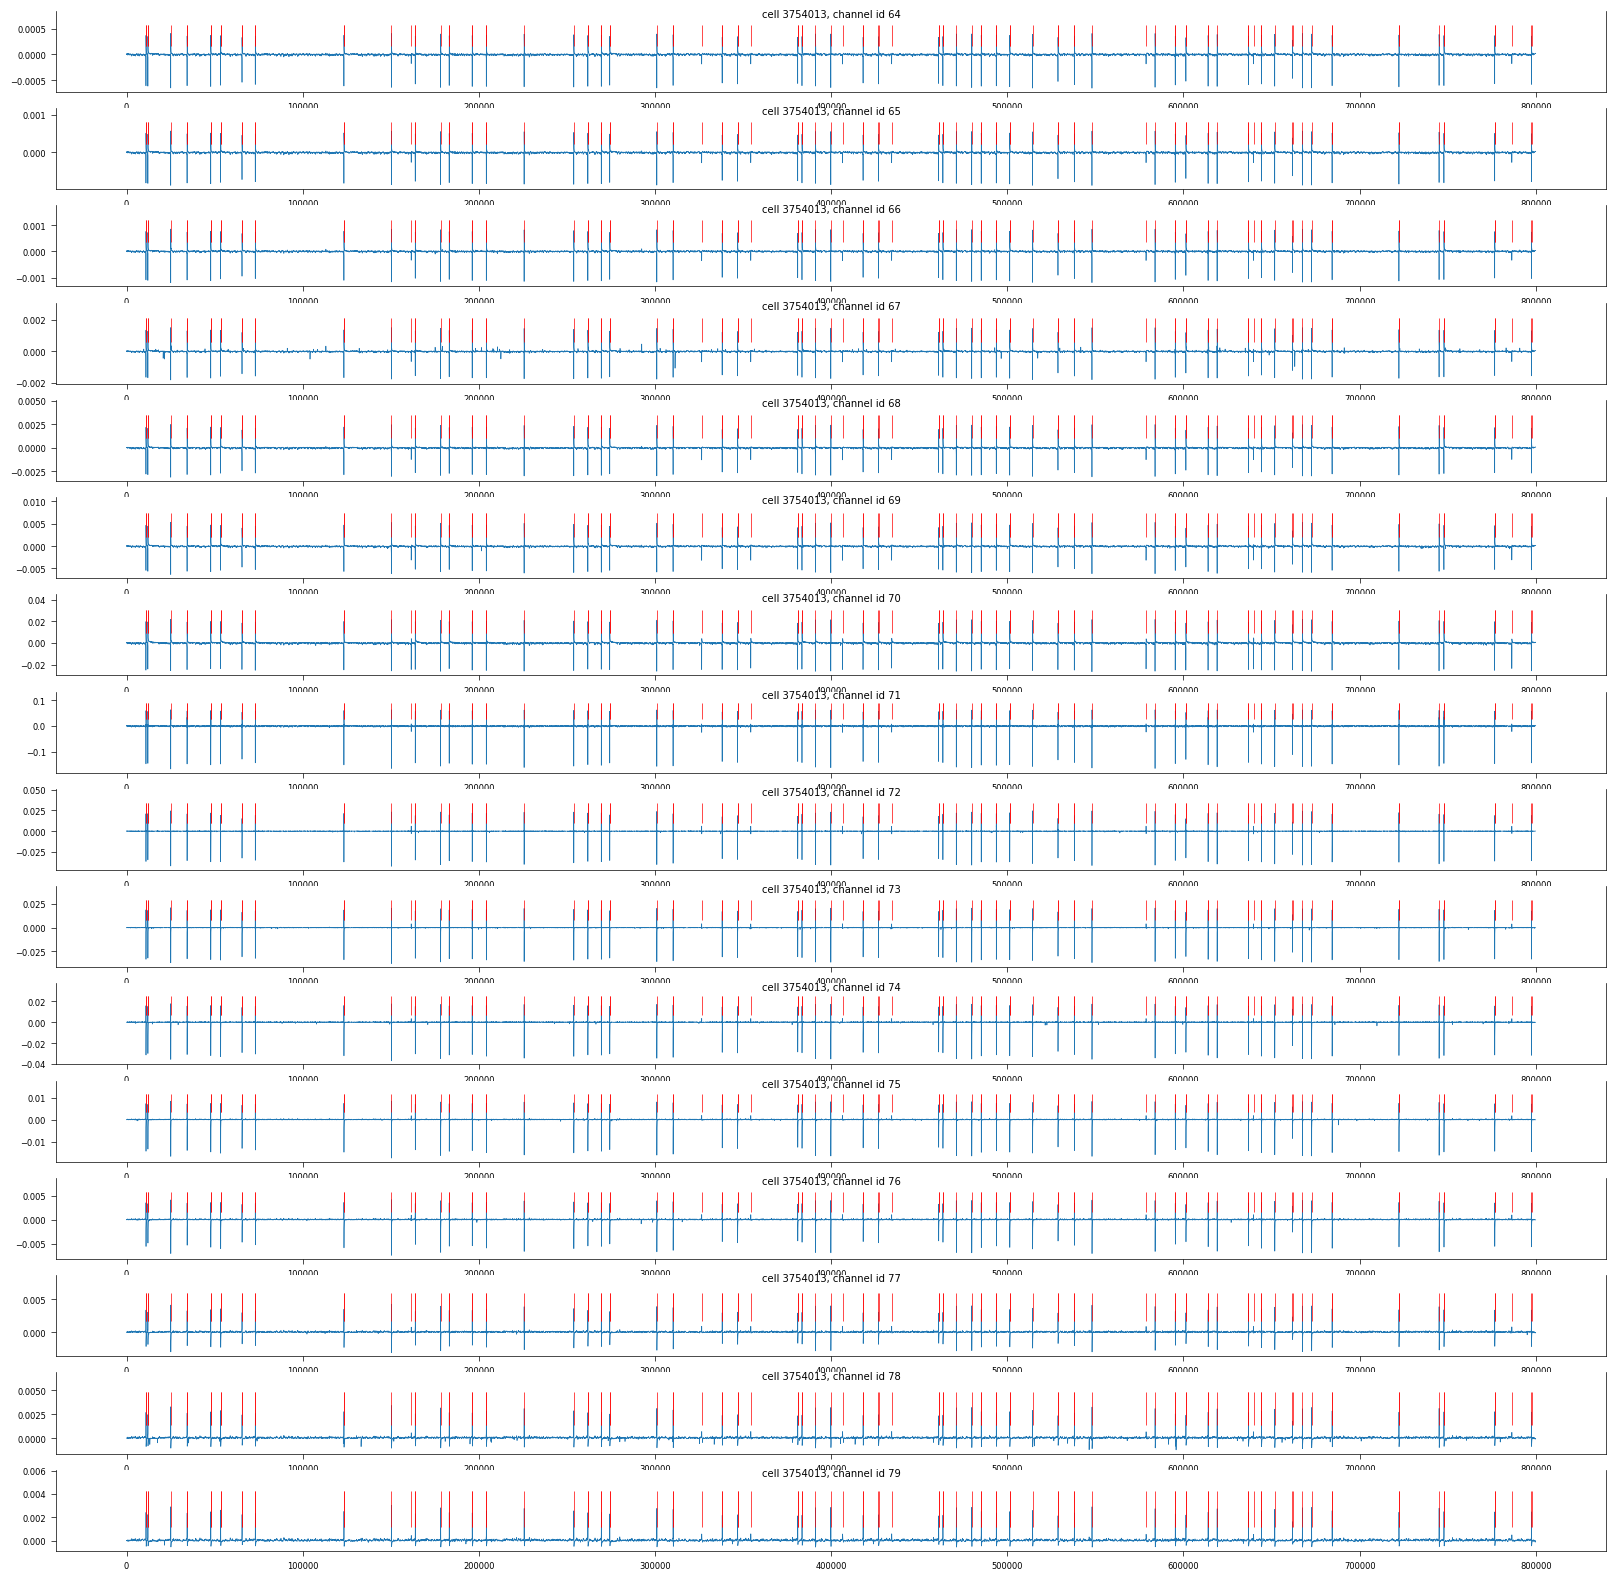

In [60]:
print(CHANNEL_IDS)
CellSortingTrue = si.load_extractor(GT_ISOLATED_CELL_PATH)
spike_sample = CellSortingTrue.get_unit_spike_train(CELL)
# spike_secs = spike_sample * (1 / (SFREQ / 1000))

CellRecording = si.load_extractor(ISOLATED_CELL_REC_PATH)
cell_traces = CellRecording.get_traces()
rec_duration_sec = CellRecording.get_total_duration()
time_sec = np.arange(0, rec_duration_sec, 1 / SFREQ)

# initialize plot
n_channels = len(CHANNEL_IDS)
fig, axes = plt.subplots(n_channels, 1, figsize=(20, 20))

# plot cell trace by channel
for c_i, c_id in enumerate(CHANNEL_IDS):

    # axes[c_i].plot(time_sec, cell_traces[:, c_id])
    axes[c_i].plot(cell_traces[:, c_id])

    # flag spikes
    MIN_MAX_AMPLITUDE = [
        cell_traces[:, c_id].min(),
        cell_traces[:, c_id].max(),
    ]

    axes[c_i].eventplot(
        spike_sample,
        linelengths=MIN_MAX_AMPLITUDE[1],
        lineoffsets=MIN_MAX_AMPLITUDE[1] * 0.9,
        colors="r",
    )
    axes[c_i].set_title(f"cell {CELL}, channel id {c_id}")

## Check cell's spikes on nearest channel

In [61]:
def get_unit_waveform(trace, spike_time, timepoint_before=60, timepoint_after=60):
    waveform = []
    for spike in spike_time:
        this_waveform = trace[
            int(spike - timepoint_before) : int(spike + timepoint_after)
        ]
        waveform.append(this_waveform)
    return waveform

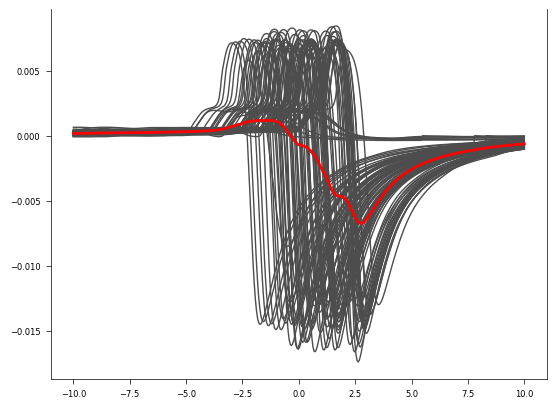

In [62]:
CHANNEL_ID = 75

ms_before = 10
timepoints_before = ms_before * SFREQ / 1000

wvs = get_unit_waveform(
    cell_traces[:, CHANNEL_ID],
    spike_sample,
    timepoint_before=timepoints_before,
    timepoint_after=timepoints_before,
)

min_len = min([len(ix) for ix in wvs])

wv2 = []
for wv in wvs:
    wv2.append(wv[:min_len])

wavef = np.array(wv2)
plt.plot(np.linspace(-10, 10, min_len), wavef.T, color=[0.3, 0.3, 0.3], linewidth=1)
plt.plot(
    np.linspace(-10, 10, min_len), np.mean(wavef.T, axis=1), color="r", linewidth=2
)

## Locate cell

In [63]:
# get chosen cell's coordinate
cell_coord = np.array([3820.476353, -1143.5028, -2538.452514])
cell_coord = pd.DataFrame(data=cell_coord, index=["x", "y", "z"])
print("cell coordinates:\n", cell_coord)

# get probe
ISOLATED_CELL_REC_PATH = data_conf["probe_wiring_isolated_cell"]["full"]["output"]
Recording = si.load_extractor(ISOLATED_CELL_REC_PATH)
probe = Recording.get_probe()

# get contact coordinates
probe_coord = probe.contact_positions.astype(float)
print("contact x-y coordinates:\n", probe_coord[:, :1])

cell coordinates:
              0
x  3820.476353
y -1143.502800
z -2538.452514
contact x-y coordinates:
 [[3333.81242423]
 [3378.99014513]
 [3424.16786603]
 [3469.34558693]
 [3514.52330784]
 [3559.70102874]
 [3604.87874964]
 [3650.05647054]
 [3695.23419145]
 [3740.41191235]
 [3785.58963325]
 [3830.76735415]
 [3875.94507506]
 [3921.12279596]
 [3966.30051686]
 [4011.47823777]
 [3382.43500685]
 [3427.61272776]
 [3472.79044866]
 [3517.96816956]
 [3563.14589046]
 [3608.32361137]
 [3653.50133227]
 [3698.67905317]
 [3743.85677407]
 [3789.03449498]
 [3834.21221588]
 [3879.38993678]
 [3924.56765769]
 [3969.74537859]
 [4014.92309949]
 [4060.10082039]
 [3431.05758948]
 [3476.23531038]
 [3521.41303129]
 [3566.59075219]
 [3611.76847309]
 [3656.94619399]
 [3702.1239149 ]
 [3747.3016358 ]
 [3792.4793567 ]
 [3837.6570776 ]
 [3882.83479851]
 [3928.01251941]
 [3973.19024031]
 [4018.36796122]
 [4063.54568212]
 [4108.72340302]
 [3479.68017211]
 [3524.85789301]
 [3570.03561391]
 [3615.21333482]
 [3660.3910

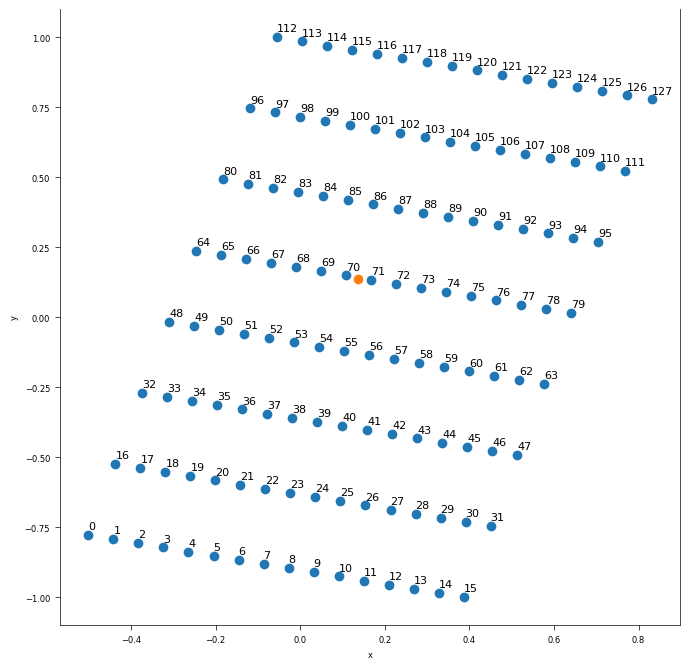

In [64]:
# scale coordinates linearly between -1 and 1 for plot (0 being the cell coordinates)
norm_contact_coord = np.subtract(probe_coord[:, :2], cell_coord.values[:2].T)
ncc = norm_contact_coord
ncc_max = norm_contact_coord.max().max()
ncc_min = norm_contact_coord.min().min()
scaled_contact_coord = (ncc - ncc_min) / (ncc_max - ncc_min) * 2 - 1

# normalize cell
norm_cell_coord = np.array([0, 0])
scaled_cell_coords = (norm_cell_coord - ncc_min) / (ncc_max - ncc_min) * 2 - 1

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(scaled_contact_coord[:, 0], scaled_contact_coord[:, 1], "o")
ax.plot(scaled_cell_coords[0], scaled_cell_coords[1], "o")
ax.set_xlabel("x")
ax.set_ylabel("y")

contact_ids = probe.device_channel_indices

# annotate contacts with their ids
for ix in range(len(probe_coord)):
    ax.text(
        scaled_contact_coord[ix, 0],
        scaled_contact_coord[ix, 1] + 0.02,
        "%s" % (str(contact_ids[ix])),
        size=8,
        zorder=1,
        color="k",
    )

## Plot cell's spike location variation

In [65]:
# calculate median spike (template) per channel (1 sec)
contact_ids = np.arange(0, 128, 1)

wavef_by_channel = []
for channel_i in range(len(contact_ids)):
    wvs = get_unit_waveform(
        cell_traces[:, channel_i],
        spike_sample,
        timepoint_before=timepoints_before,
        timepoint_after=timepoints_before,
    )
    min_len = min([len(ix) for ix in wvs])
    wv2 = []
    for wv in wvs:
        wv2.append(wv[:min_len])
    mean_wavef = np.mean(np.array(wv2), axis=0)
    wavef_by_channel.append(mean_wavef)
all_spikes = np.array(wavef_by_channel)
all_spikes = all_spikes.T

* It is log10 to see the peak to peak amplitude decrease

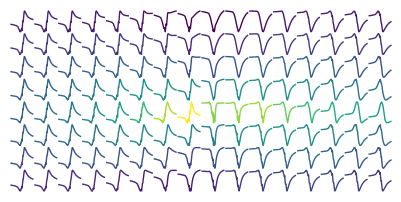

In [66]:
# plot spike location dependence
contact_ids = np.arange(0, 128, 1)
contact_grid = contact_ids.reshape(8, 16)

fig, axes = plt.subplots(contact_grid.shape[0], contact_grid.shape[1], figsize=(4, 2))

plt.rcParams["axes.titley"] = 0.82

# get peak to peak amplitude (ppa)
min_s = all_spikes.min(axis=0)
max_s = all_spikes.max(axis=0)
peak_to_peak_amp = max_s - min_s

# map ppa to spike templates (logscale)
df = pd.DataFrame(
    {"ppa": np.log10(peak_to_peak_amp), "contact": np.arange(0, 128, 1)}
).sort_values(by="ppa", ascending=True)

# convert peak to peak amplitude to color gradient
color_intensity = (df["ppa"] - df["ppa"].min()) / (df["ppa"].max() - df["ppa"].min())
cmap = plt.cm.viridis(color_intensity)
df["colors"] = cmap.tolist()

df = df.sort_values(by="contact")


# plot each contact's average spike panel in the x-y plane
c_i = 0
for ix in range(contact_grid.shape[0]):
    for jx in range(contact_grid.shape[1]):
        axes[ix, jx].plot(
            all_spikes[:, contact_grid[ix, jx]],
            color=df["colors"].iloc[c_i],
            linewidth=1,
        )
        axes[ix, jx].axis("off")
        # axes[ix, jx].set_title(contact_grid[ix, jx], fontsize=8, loc="left")
        c_i += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# SAVE FIGURE AS PDF
utils.savefig("figures/0_validation/5_spikes/6_shape/svg/spatial_variation.svg")

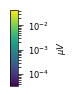

In [67]:
# get logscale colorbar
fig, ax = plt.subplots(figsize=(0.1, 2))
fig.subplots_adjust(bottom=0.5)
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.LogNorm(
    vmin=peak_to_peak_amp.min(), vmax=peak_to_peak_amp.max()
)
fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation="vertical",
    label="$\mu V$",
)

# SAVE FIGURE AS PDF
utils.savefig(
    "figures/0_validation/5_spikes/6_shape/svg/spatial_variation_colorbar.svg"
)

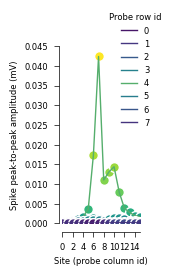

In [68]:
fig, ax = plt.subplots(figsize=(1, 2.3))

contact_id = [
    np.arange(0, 16, 1),
    np.arange(16, 32, 1),
    np.arange(32, 48, 1),
    np.arange(48, 64, 1),
    np.arange(64, 80, 1),
    np.arange(80, 96, 1),
    np.arange(96, 112, 1),
    np.arange(112, 128, 1),
]

for row_i in range(len(contact_id)):
    for ix, c_id in enumerate(contact_id[row_i]):
        plt.plot(
            ix,
            peak_to_peak_amp[c_id],
            color=df["colors"].iloc[c_id],
            marker="o",
            markersize=7,
            markeredgecolor="w",
        )

    # row color is averaged color over row's contacts
    color_row = np.array(
        [color_i for color_i in df["colors"].loc[contact_id[row_i]]]
    ).mean(axis=0)
    plt.plot(
        peak_to_peak_amp[contact_id[row_i]],
        color=color_row,
        linewidth=1,
        label=f"{row_i}",
    )

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.spines[["right", "top"]].set_visible(False)

ax.set_xticks(np.arange(0, 15, 2))

ax.set_ylim([0, 0.045])
ax.set_xlim([0, 15])
ax.set_ylabel("Spike peak-to-peak amplitude (mV)")
ax.set_xlabel("Site (probe column id)")
legend = ax.legend(
    fontsize=6, title="Probe row id", frameon=False, bbox_to_anchor=(0.5, 0.5)
)

# peak-to-peak amplitude
utils.savefig(
    "figures/0_validation/5_spikes/6_shape/svg/peak2peak_amplitude_change.svg"
)

In [12]:
# circuit = bluepysnap.Circuit(circuit_path)
# load parameters from the first simulation "BlueConfig" file
simulation_params = load_campaign_params(data_conf_full_circuit)

# get target units
SortingTrue = si.load_extractor(GT_ISOLATED_CELL_PATH)


def get_exc_morph_paths(circuit):
    # nodes = circuit.nodes["S1nonbarrel_neurons"]

    df = circuit.cells.get(SortingTrue.unit_ids, properties=["mtype", "morphology"])
    df.drop_duplicates(subset="morphology", ignore_index=True, inplace=True)

    df["morph_path"] = (
        df["morphology"]
        .apply(lambda row: os.path.join(circuit.config["morphologies"], "%s.asc" % row))
        .astype(str)
    )
    df.drop("morphology", axis=1, inplace=True)
    morph_paths = df.groupby("mtype")["morph_path"].apply(list)

    # get rid of INTs (because of categorical objects...)
    morph_paths = morph_paths[morph_paths.apply(len) > 0]
    return morph_paths


def get_features(morph_paths):
    """Get morphometric features for all morphologies passed"""
    features = {"mtype": [], "feature_name": [], "feature_val": [], "loc": []}
    for mtype, paths in tqdm(morph_paths.items(), desc="mtypes"):
        for path in tqdm(
            paths, desc="morphologies", miniters=len(paths) / 100, leave=False
        ):
            morph = nm.load_morphology(path)
            for neurite_name, neurite_id in NEURITES.items():
                for feature in FEATURES:
                    features["mtype"].append(mtype)
                    feature_name = (
                        "avg_section_length"
                        if feature == "section_lengths"
                        else feature
                    )
                    features["feature_name"].append(feature_name)
                    feature_val = nm.get(feature, morph, neurite_type=neurite_id)
                    feature_val = (
                        np.mean(feature_val)
                        if feature == "section_lengths"
                        else feature_val
                    )
                    features["feature_val"].append(feature_val)
                    features["loc"].append(neurite_name)
    df = pd.DataFrame.from_dict(features)
    df.drop(
        df.loc[(df["mtype"] == "L4_SSC") & (df["loc"] == "apical")].index, inplace=True
    )  # clear L4_SSC apicals...
    return df

2024-11-21 11:02:42,016 - bluepy_configfile.configfile - configfile.py - validate - WARNING - Have keys ({'desired_unconnected_fr_L4E', 'LFPWeightsPath', 'desired_unconnected_fr_L4I', 'desired_unconnected_fr_L5I', 'desired_unconnected_fr_L6E', 'desired_connected_fr_L4I', 'desired_connected_fr_L1I', 'desired_connected_fr_L23E', 'desired_connected_fr_L6E', 'depol_stdev_mean_ratio', 'desired_connected_fr_L6I', 'desired_connected_proportion_of_invivo_frs', 'desired_unconnected_fr_L5E', 'desired_connected_fr_L5I', 'desired_connected_fr_L5E', 'desired_unconnected_fr_L6I', 'desired_unconnected_fr_L1I', 'desired_unconnected_fr_L23E', 'desired_unconnected_fr_L23I', 'desired_connected_fr_L4E', 'desired_connected_fr_L23I'}) that are not defined for section: Run
2024-11-21 11:02:42,043 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unknown key: 'LFPWeightsPath'
2024-11-21 11:02:42,044 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unkno

2024-11-21 11:02:42,046 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unknown key: 'desired_connected_proportion_of_invivo_frs'
2024-11-21 11:02:42,048 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unknown key: 'desired_unconnected_fr_L1I'
2024-11-21 11:02:42,054 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unknown key: 'desired_unconnected_fr_L23E'
2024-11-21 11:02:42,054 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unknown key: 'desired_unconnected_fr_L23I'
2024-11-21 11:02:42,056 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unknown key: 'desired_unconnected_fr_L4E'
2024-11-21 11:02:42,058 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unknown key: 'desired_unconnected_fr_L4I'
2024-11-21 11:02:42,060 - bluepy_configfile.configfile - configfile.py - to_dict - WARNING - Ignoring unknown key: 'de

In [91]:
SAVE = True

if SAVE:
    morph_paths = get_exc_morph_paths(simulation_params["circuit"])
    cell = nm.load_morphology(morph_paths[0][0])
    cell.write("assets/morph_cell_3754013.h5")
else:
    cell = nm.load_morphology("assets/morph_cell_3754013.h5")
fig, ax = plotly_impl.plot_morph(cell, plane="xy", inline=True)

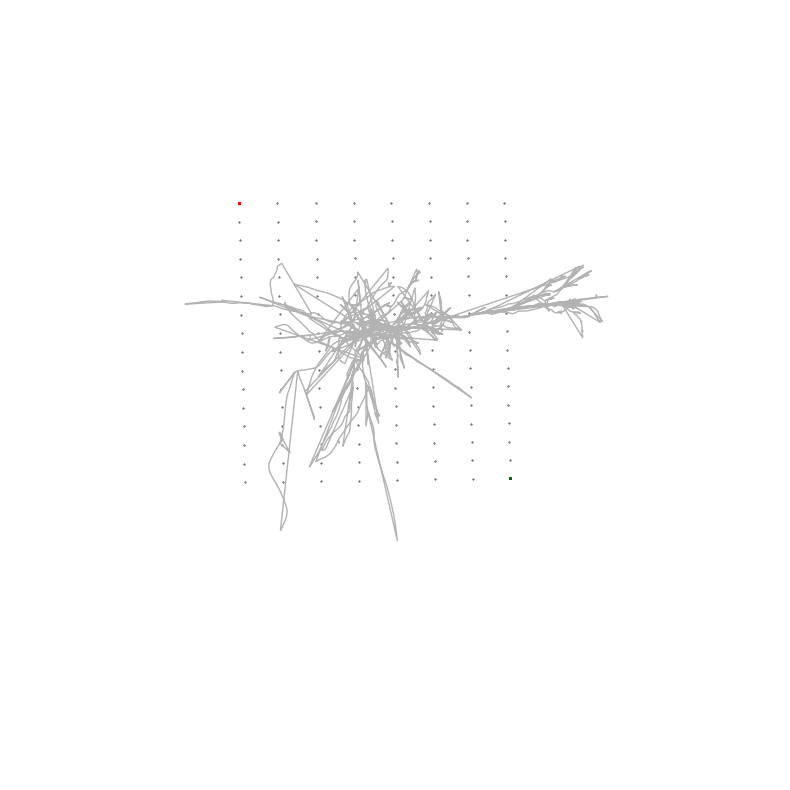

In [396]:
# scale coordinates linearly between -1 and 1 for plot (0 being the cell coordinates)
fig = plt.figure(figsize=(60, 10))
ax = fig.add_subplot(projection="3d")
ax.view_init(150, 0, 8)

contact_ids = probe.device_channel_indices
cell_x = cell_coord.values[0]
cell_y = cell_coord.values[1]
cell_z = cell_coord.values[2]

# annotate contacts with their ids
# plot electrodes
for ix in range(len(probe_coord)):
    ax.plot3D(
        probe_coord[ix, 0],
        probe_coord[ix, 1],
        probe_coord[ix, 2],
        "k",
        marker=".",
        markersize=0.7,
    )
    #
    ax.plot3D(
        probe_coord[0, 0],
        probe_coord[0, 1],
        probe_coord[0, 2],
        "r",
        marker=".",
        markersize=0.7,
    )
    ax.plot3D(
        probe_coord[-1, 0],
        probe_coord[-1, 1],
        probe_coord[-1, 2],
        "g",
        marker=".",
        markersize=0.7,
    )

# plot cell
ax.plot3D(
    cell_x + cell.points[:, 0],
    cell_y + cell.points[:, 1],
    cell_z + cell.points[:, 2],
    color=[0.7, 0.7, 0.7],
    linewidth=1,
)

ax.set_box_aspect(aspect=(3, 4, 4))
ax.axis("off")

# save
utils.savefig("figures/0_validation/5_spikes/6_shape/svg/cell_morph_to_overlap.svg")